In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

In [2]:
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
    def gradient(self,x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F
    
    def gradient_discrete(self, R, dt, T, orbit, y):
        ll = np.zeros((T + 2, self.N))
        for t in range(T-1, -1, -1):
            M = np.zeros((self.N,self.N))
            
            M[0][self.N-2] = -dt * orbit[t-1][self.N-1]
            M[0][self.N-1] = dt * (orbit[t-1][1] - orbit[t-1][self.N-2])
            M[0][0] = 1 - dt
            M[0][1] = dt * orbit[t-1][self.N-1]
    
            M[1][self.N-1] = -dt * orbit[t-1][0]
            M[1][0] = dt * (orbit[t-1][2] - orbit[t-1][self.N-1])
            M[1][1] = 1 - dt
            M[1][2] = dt * orbit[t-1][0]
    
            M[self.N-1][self.N-3] = -dt * orbit[t-1][self.N-2]
            M[self.N-1][self.N-2] = dt * (orbit[t-1][0] - orbit[t-1][self.N-3])
            M[self.N-1][self.N-1] = 1 - dt
            M[self.N-1][0] = dt * orbit[t-1][self.N-2]
    
            for i in range(2,self.N-1):
                M[i][i-2] = -dt * orbit[t-1][i-1]
                M[i][i-1] = dt * (orbit[t-1][i+1] - orbit[t-1][i-2])
                M[i][i] = 1 - dt
                M[i][i+1] = dt * orbit[t-1][i-1]
    
            ll[t] = (np.transpose(M)).dot(ll[t+1]) + np.linalg.inv(R).dot(orbit[t] - y[t])
        return ll[0]
    
    def gradient_adjoint(self, la, x, y):
        m = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    m[j][i] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    m[j][i] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    m[j][i] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    m[j][i] -= 1
        gr = -m @ la - (x - y)
        return gr

class RungeKutta4:
    def __init__(self, callback, N, dt, t, x):
        self.callback = callback
        self.N = N
        self.dt = dt
        self.t = t
        self.x = x

    def nextstep(self):
        k1 = handler(self.callback, self.t, self.x)
        k2 = handler(self.callback, self.t + self.dt/2, self.x + k1*self.dt/2)
        k3 = handler(self.callback, self.t + self.dt/2, self.x + k2*self.dt/2)
        k4 = handler(self.callback, self.t + self.dt  , self.x + k3*self.dt)
        self.t += self.dt
        self.x += (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def orbit(self,T):
        steps = int(T/self.dt) + 1
        o = np.zeros((steps,self.N))
        o[0] = self.x
        for i in range(steps):
            o[i] = self.nextstep()
        return o
    
    def nextstep_gradient(self):
        self.nextstep()
        return self.dt * self.callback(self.t, self.x)
    
    def orbit_gradient(self, T):
        steps = int(T/self.dt)
        gr = np.zeros((steps,N))
        gr[0] = self.dt * self.callback(self.t, self.x)
        for i in range(steps):
            gr[i] = self.nextstep_gradient()
        return gr


class AdjointRungeKutta4:
    def __init__(self, callback, N, T, dt, x, y):
        self.callback = callback
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.steps = int(T/self.dt) + 1
        
    def orbit_adjoint(self):
        la = np.zeros((self.steps, N))
        for i in range(self.steps-1, 0, -1):
            k1 = handler(self.callback, i, la[i], self.x[i], self.y[i])
            k2 = handler(self.callback, i - self.dt/2, la[i] + k1*self.dt/2, self.x[i], self.y[i])
            k3 = handler(self.callback, i - self.dt/2, la[i] + k2*self.dt/2, self.x[i], self.y[i])
            k4 = handler(self.callback, i - self.dt  , la[i] + k3*self.dt, self.x[i], self.y[i])
            la[i-1] = la[i] - (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return la
    
    def minimizer_gradient(self):
        la = self.orbit_adjoint()
        return la[0]


class Adjoint:
    def __init__(self, dx, dla, N, T, dt, x, y):
        self.dx = dx
        self.dla = dla
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.steps = int(T/self.dt) + 1
        
    def orbit(self):
        for i in range(self.steps-1):
            k1 = handler(self.dx, self.x[i])
            k2 = handler(self.dx, self.x[i] + k1*self.dt/2)
            k3 = handler(self.dx, self.x[i] + k2*self.dt/2)
            k4 = handler(self.dx, self.x[i] + k3*self.dt)
            self.x[i+1] = self.x[i] + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return self.x
    
    def observed(self, stddev):
        self.orbit()
        for i in range(self.steps):
            self.x[i] += stddev * np.random.randn()
        return self.x
    
    def gradient(self):
        la = np.zeros((self.steps, self.N))
        for i in range(self.steps-1, 0, -1):
            k1 = handler(self.dla, la[i], self.x[i], self.y[i])
            k2 = handler(self.dla, la[i] - k1*self.dt/2, self.x[i], self.y[i])
            k3 = handler(self.dla, la[i] - k2*self.dt/2, self.x[i], self.y[i])
            k4 = handler(self.dla, la[i] - k3*self.dt,   self.x[i], self.y[i])
            la[i-1] = la[i] - (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        la = np.zeros((self.steps, self.N))
        for i in range(self.steps-1, 0, -1):
            k1 = handler(self.dla, la[i], self.x[i], self.y[i])
            k2 = handler(self.dla, la[i] - k1*self.dt/2, self.x[i], self.y[i])
            k3 = handler(self.dla, la[i] - k2*self.dt/2, self.x[i], self.y[i])
            k4 = handler(self.dla, la[i] - k3*self.dt,   self.x[i], self.y[i])
            la[i-1] = la[i] - (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
        return la[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps):
            cost += (self.x[i] - self.y[i]) @ (self.x[i] - self.y[i])
        return cost
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(N)
        c1 = self.cost(x0)
        for j in range(N):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr

def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

## Orbit using scipy library

<IPython.core.display.Javascript object>


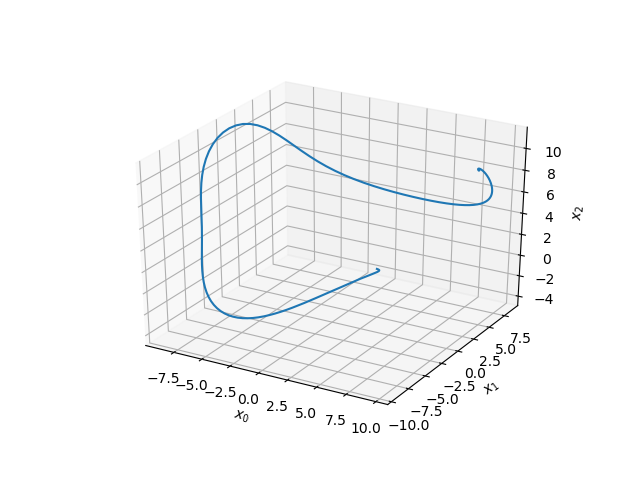

In [3]:
N = 4
F = 8
#x0 = F * np.ones(N)
#x0[3] += 0.01
#lorenz = Lorenz96(N, F)
#scheme = RungeKutta4(lorenz.gradient, N, 0.001, 0, x0)
#o = scheme.orbit(10.)
#plot_orbit(o)
#
from scipy.integrate import odeint
def lorenz96(x,t):
    # compute state derivatives
    d = np.zeros(N)
    # first the 3 edge cases: i=1,2,N
    d[0] = (x[1] - x[N-2]) * x[N-1] - x[0]
    d[1] = (x[2] - x[N-1]) * x[0]- x[1]
    d[N-1] = (x[0] - x[N-3]) * x[N-2] - x[N-1]
    # then the general case
    for i in range(2, N-1):
        d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
    # add the forcing term
    d = d + F
    
    # return the state derivatives
    return d

# pdb.set_trace()
x0 = F*np.ones(N) # initial state (equilibrium)
x0[0] += 0.01 # add small perturbation to 20th variable
t = np.arange(0.0, 2.0+0.01, 0.01)

x = odeint(lorenz96, x0, t)

plot_orbit(x)

y


<IPython.core.display.Javascript object>


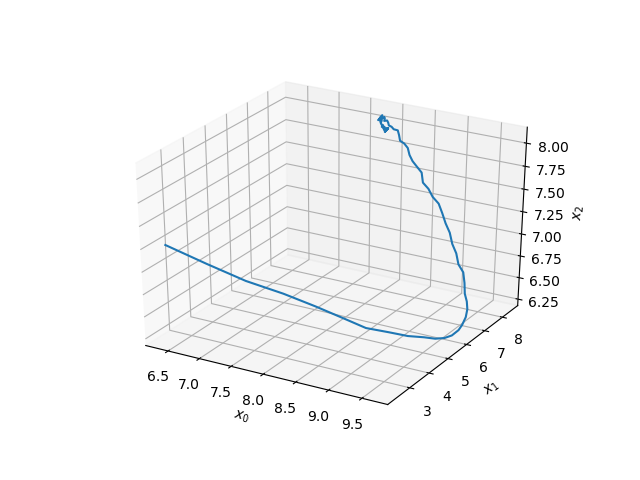

x


<IPython.core.display.Javascript object>


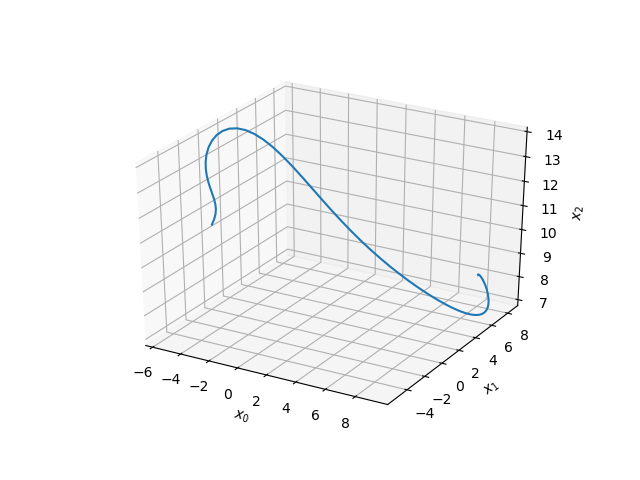

[-450.52842799 -187.59189447  455.63506179  195.51262348]
[-91640.65593468 -42654.38727416  92681.56125181  44237.37496872]
      fun: 0.048328344992691154
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00059418, -0.00064705,  0.00046793, -0.00056074])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 27
   status: 0
  success: True
        x: array([ 8.03083307,  7.97865923,  8.02081944,  7.97866099])


<IPython.core.display.Javascript object>


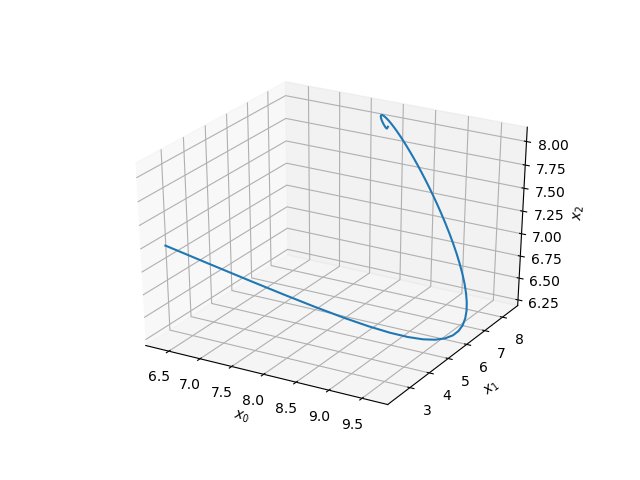

<IPython.core.display.Javascript object>


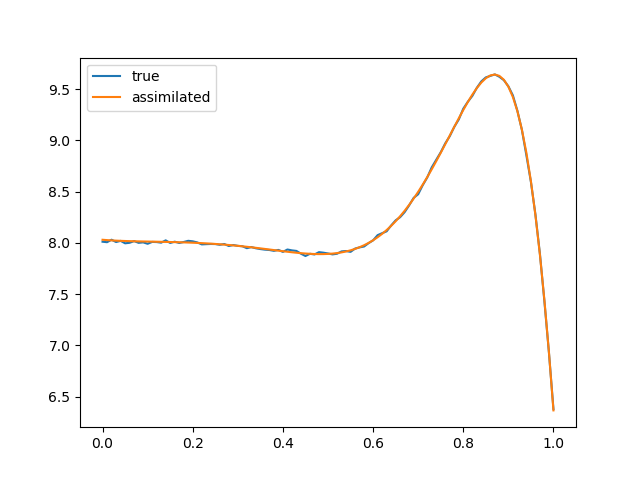

<IPython.core.display.Javascript object>


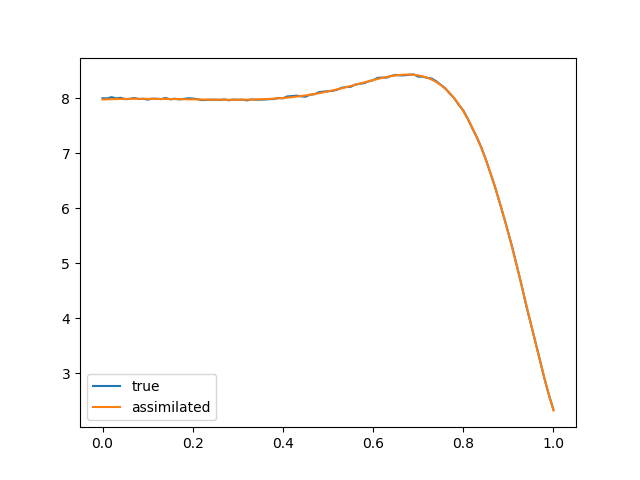

<IPython.core.display.Javascript object>


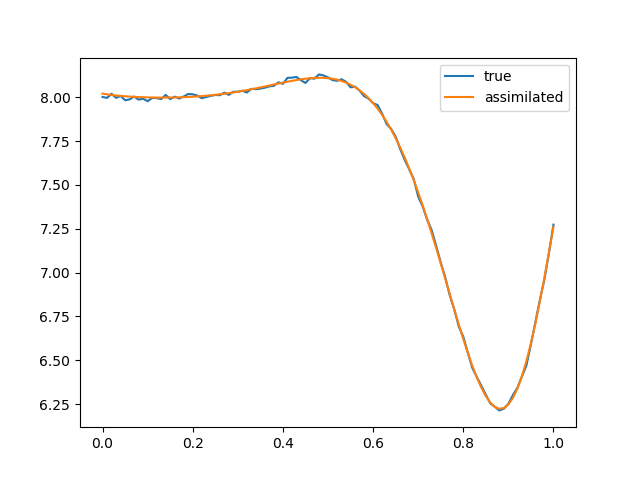

<IPython.core.display.Javascript object>


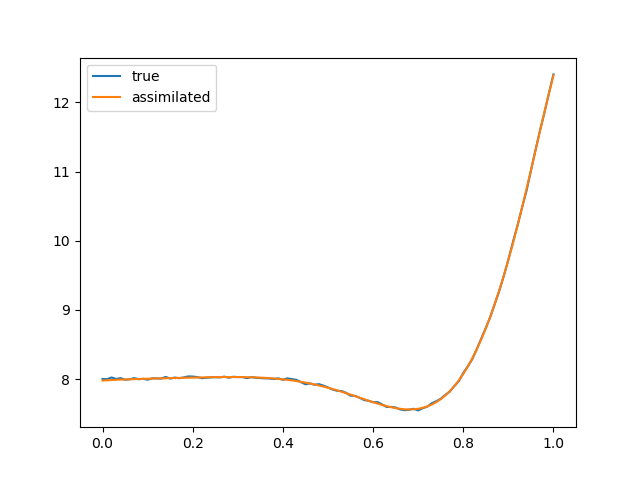

In [21]:
from scipy.optimize import minimize

N = 4
F = 8
T = 1.
dt = 0.01
steps = int(T/dt) + 1

lorenz = Lorenz96(N, F)

t = np.arange(0., T + dt, dt)
x = np.zeros((steps, N))
y = np.zeros((steps, N))

x[0] = F * np.ones(N)
x[0][0] += 0.01

scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, x, y)

scheme.y = np.copy(scheme.observed(0.01))
print("y")
plot_orbit(scheme.y)

x_opt = F * np.ones(N)
x_opt[2] += 0.1
scheme.cost(x_opt)
print("x")
#print (scheme.x)
z = np.copy(scheme.x)
#plot_orbit(scheme.x)
plot_orbit(z)

gr_anal = scheme.gradient_from_x0(x_opt)
print (gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.00001)
print (gr_num)

#scheme.x[0] = F * np.ones(N)
#scheme.x[0][0] += 0.01
#
#objective_func_gradient = scheme.gradient()
#
#print (objective_func_gradient)
#
#plt.plot(t,[item[0] for item in y])
#plt.show()


#print (scheme.gradient_from_x0(x_opt))

# res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', options={'gtol': 1e-6, 'disp': True})
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B')
print (res)

#scheme.cost(res.x)
#plot_orbit(scheme.x)

x2 = np.zeros((steps, N))
x2[0] = np.copy(res.x)
scheme2 = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, N, T, dt, x2, y)
ans = np.copy(scheme2.orbit())
plot_orbit(ans)

for j in range(N):
    fig = plt.figure()
    plt.plot(t,[item[j] for item in scheme.y], label='true')
    plt.plot(t,[item[j] for item in ans], label='assimilated')
    plt.legend()
    plt.show()
